In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import pandas as pd 

In [2]:
def gaussian_k(x0,y0,sigma, width, height):
        """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
        """
        x = np.arange(0, width, 1, float) ## (width,)
        y = np.arange(0, height, 1, float)[:, np.newaxis] ## (height,1)
        return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

def generate_hm(height, width ,points,sigma):
        """ Generate a full Heap Map for every points in an array
        Args:
            height    : The height of Heat Map (the height of target output)
            width     : The width  of Heat Map (the width of target output)
        """
        hm = np.zeros((height, width, len(points)), dtype = np.float32)
        for i in range(len(points)):
            hm[:,:,i] = gaussian_k(points[i][0],
                                    points[i][1],
                                    sigma, width, height)
        return hm
    
def get_y_as_heatmap(keypoints,height,width, sigma): 
    return np.array([generate_hm(height, width, image_keypoints / 5., sigma) for image_keypoints in keypoints], dtype=np.float32)

In [3]:
def load_keypoints(image_number):
    return np.load(f'./keypoints/00{image_number}_gt_keypoints2d.npy')

def load(width=128,height=96,sigma=3, image_number=10):
    """
    load test/train data
    cols : a list containing landmark label names.
           If this is specified, only the subset of the landmark labels are 
           extracted. for example, cols could be:
           
          [left_eye_center_x, left_eye_center_y]
            
    return: 
    heatmaps:  2-d numpy array (Nsample, Nlandmarks*2) 
    """
    from sklearn.utils import shuffle
    
    keypoints = load_keypoints(image_number)
    heatmaps = get_y_as_heatmap(keypoints, height, width, sigma)
    return heatmaps

def load_many(width=128, height=96, sigma=3, image_folders=['10']):        
    return np.vstack([load(width, height, sigma, no) for no in image_folders])

In [4]:
heatmaps_train = load_many(image_folders=['10', '11', '18', '24', '30', '37'])
heatmaps_train.shape

(1522, 96, 128, 9)

In [5]:
heatmaps_test = load_many(image_folders=['50'])
n_test = heatmaps_test.shape[0]
heatmaps_test.shape

(320, 96, 128, 9)

In [6]:
from pathlib import Path
root = Path().cwd()/"images"

images = tf.keras.preprocessing.image_dataset_from_directory(
    root,
    image_size=(96, 128),
    shuffle=False
)

images, _ = zip(*images.unbatch())
images = np.array(images)

images.shape

Found 1842 files belonging to 7 classes.


(1842, 96, 128, 3)

In [7]:
images_train, images_test = images[:-n_test], images[-n_test:]

images_train.shape, images_test.shape

((1522, 96, 128, 3), (320, 96, 128, 3))

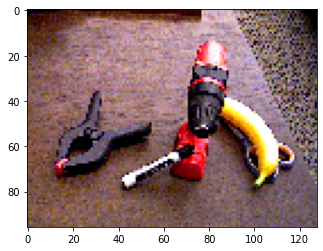

In [8]:
images /= 255.
plt.imshow(images[0])

In [9]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(images, heatmaps, test_size=0.2, random_state=42)

## Visualize image together with heatmap

C:\Users\MatiX\AppData\Local\Temp/ipykernel_5652/296620522.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, keypoint_number/2, 1)
C:\Users\MatiX\AppData\Local\Temp/ipykernel_5652/296620522.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, keypoint_number/2, i+2)


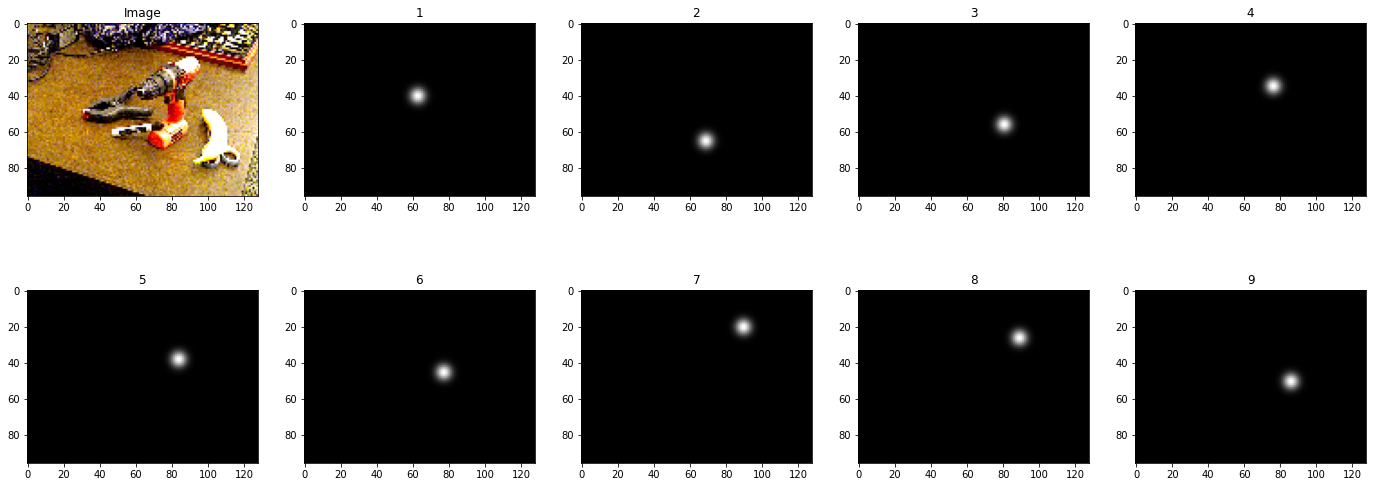

In [10]:
idx = 100

def plot_image_with_keypoints_heatmap(image, heatmap):
    keypoint_number = heatmap.shape[2]+1

    fig = plt.figure(figsize=(24,9))
    ax = fig.add_subplot(2, keypoint_number/2, 1)
    ax.imshow(image)
    ax.set_title("Image")
    for i in range(heatmaps_train.shape[-1]):
        ax = fig.add_subplot(2, keypoint_number/2, i+2)
        ax.imshow(heatmap[:,:,i],cmap="gray")
        ax.set_title(str(i+1))
    plt.show()

plot_image_with_keypoints_heatmap(images_train[idx], heatmaps_train[idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


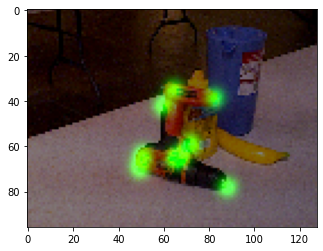

In [11]:
idx = 1000

def plot_image_with_heatmaps(image, heatmap):
    image = image.copy()
    image *= 0.5

    for i in range(9):
        image[:, :, 1] = image[:, :, 1] + heatmap[:,:,i]

    plt.imshow(image)
    
plot_image_with_heatmaps(images_train[idx], heatmaps_train[idx])

# Model

In [12]:
from stacked_hourglass import create_stacked_hourglass_model

N_KEYPOINTS = 9
N_HOURGLASSES = 4
START_FILTERS = 32
MAX_FILTERS = 128

In [13]:
img_input = tf.keras.Input(shape=(96, 128, 3))
stacked_hourglass_model = create_stacked_hourglass_model(img_input, 
                                                         N_KEYPOINTS, 
                                                         N_HOURGLASSES, 
                                                         START_FILTERS, 
                                                         MAX_FILTERS, 
                                                         mode='simple')

# stacked_hourglass_model.load_weights('./model_checkpoints/')

# Training

In [14]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./model_checkpoints/', save_weights_only=True)

stacked_hourglass_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                                loss=tf.keras.losses.mean_squared_error)
model_history = stacked_hourglass_model.fit(images_train, heatmaps_train, batch_size=32, epochs=10, validation_data=(images_test, heatmaps_test), callbacks=[cp_callback])

Epoch 1/10
48/48 [==============================] - 18s 260ms/step - loss: 0.0180 - output_0_loss: 0.0037 - output_1_loss: 0.0034 - output_2_loss: 0.0037 - output_3_loss: 0.0071 - val_loss: 0.0092 - val_output_0_loss: 0.0024 - val_output_1_loss: 0.0023 - val_output_2_loss: 0.0023 - val_output_3_loss: 0.0023
Epoch 2/10
48/48 [==============================] - 11s 231ms/step - loss: 0.0090 - output_0_loss: 0.0023 - output_1_loss: 0.0022 - output_2_loss: 0.0022 - output_3_loss: 0.0022 - val_loss: 0.0091 - val_output_0_loss: 0.0023 - val_output_1_loss: 0.0023 - val_output_2_loss: 0.0023 - val_output_3_loss: 0.0023
Epoch 3/10
48/48 [==============================] - 12s 242ms/step - loss: 0.0088 - output_0_loss: 0.0022 - output_1_loss: 0.0022 - output_2_loss: 0.0022 - output_3_loss: 0.0022 - val_loss: 0.0091 - val_output_0_loss: 0.0022 - val_output_1_loss: 0.0023 - val_output_2_loss: 0.0023 - val_output_3_loss: 0.0023
Epoch 4/10
48/48 [==============================] - 11s 234ms/step - loss

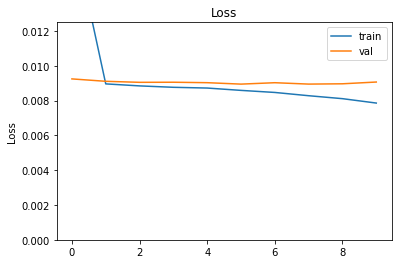

In [15]:
def plot_stats(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('Loss')
    ax = plt.gca()
    ax.set_ylim([0.0, 0.0125])
    plt.legend(['train', 'val'])
    plt.show()
    
plot_stats(model_history)

# Evaluation

## Predicted

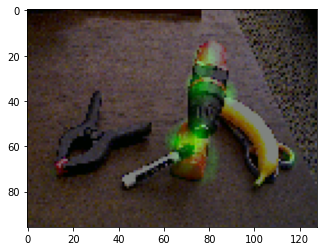

In [58]:
idx = 0

image = images_train[idx]
pred_heatmaps = stacked_hourglass_model.predict(np.array([image]))[-1][0]

plot_image_with_heatmaps(image, pred_heatmaps)

## Ground truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


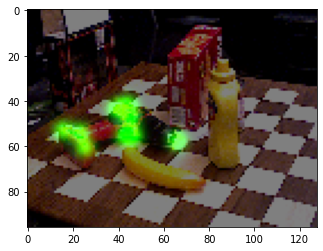

In [33]:
idx = 100

image = images_test[idx]
heatmaps = heatmaps_test[idx]

plot_image_with_heatmaps(image, heatmaps)

# Retrieving keypoints from heatmaps

In [66]:
def retrieve_keypoint(heatmap):
    indices = np.unravel_index(np.argmax(heatmap), heatmap.shape)
    return indices

def retrieve_keypoints(heatmaps):
    keypoints = []
    for i in range(heatmaps.shape[2]):
        keypoints.append(np.array(retrieve_keypoint(heatmaps[:, :, i]), dtype=np.int32))
        
    return np.array(keypoints)

def pred_all(model, im_train, im_test, batch=50):
    pred_heatmaps = []
    for dataset_images in [im_train, im_test]:
        for i in range(0, dataset_images.shape[0], batch):
            # print(i)
            pred_heatmaps.append(model.predict(dataset_images[i:(i+batch)])[-1])
                                 
    return np.vstack(pred_heatmaps)

In [67]:
pred_heatmaps = pred_all(stacked_hourglass_model, images_train, images_test)
pred_heatmaps.shape

(1842, 96, 128, 9)

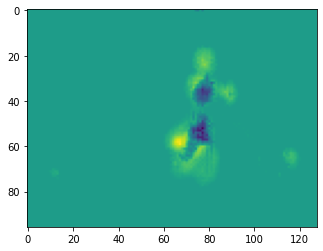

In [68]:
plt.imshow(pred_heatmaps[0, :, :, 0])

In [50]:
retrieve_keypoints(pred_heatmaps[0])

array([[59, 67],
       [59, 67],
       [56, 75],
       [56, 75],
       [57, 74],
       [56, 75],
       [59, 67],
       [59, 67],
       [59, 67]])

In [45]:
np.argmax(pred_heatmaps[10][:, :, 0])

7355

In [22]:
load_keypoints('10')[0] / 5

array([[77.4, 55. ],
       [66.8, 71.8],
       [68.6, 55. ],
       [72.4, 37.8],
       [83.8, 40. ],
       [76.8, 49.6],
       [78.4, 16. ],
       [77.2, 22.2],
       [75.6, 48. ]])

# Save keypoints

In [23]:
def save_keypoints(keypoints):
    with open('results.npy', 'wb') as f:
        np.save(f, keypoints)

In [24]:
save_keypoints(pred_keypoints)

NameError: name 'pred_keypoints' is not defined